<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-01-17 20:02:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-01-17 20:02:36 (16.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

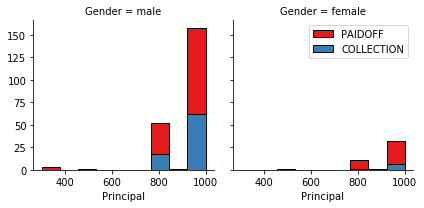

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

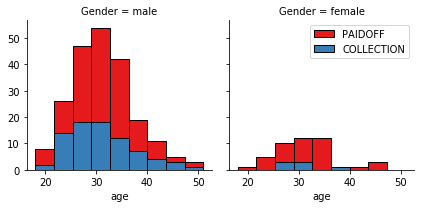

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

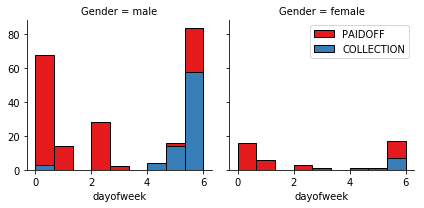

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model

You should use the following algorithms:
- K Nearest Neighbor (KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Custom pre-processing

I will order the data so that is it possible to make balanced train and test sets.

In [20]:
# Back to original dataframe
new_df = pd.concat([Feature, df['loan_status']], axis=1)

# Binary values for the targets
new_df['loan_status'].replace({'PAIDOFF': -1, 'COLLECTION': 1}, inplace=True)

# Order by target
new_df.sort_values(by=['loan_status'], inplace=True)

# Get targets and features
target = new_df['loan_status'].values
temp = new_df[['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor', 'High School or Below', 'college']]
features = preprocessing.StandardScaler().fit(temp).transform(temp)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [21]:
# Separate into train and test sets
from sklearn.model_selection import train_test_split

# Separate train and test sets in a balanced way
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.15, random_state=42, stratify=target)
print ('Train set:', features_train.shape,  target_train.shape)
print ('Test set:', features_test.shape,  target_test.shape)

#print(f'\n\n{features_train[0]}\n\n')

unique, counts = np.unique(target, return_counts=True)
print(f'Total set distribution: {dict(zip(unique, counts))}')

unique, counts = np.unique(target_train, return_counts=True)
print(f'Train set distribution: {dict(zip(unique, counts))}')

unique, counts = np.unique(target_test, return_counts=True)
print(f'Test set distribution: {dict(zip(unique, counts))}')


Train set: (294, 8) (294,)
Test set: (52, 8) (52,)
Total set distribution: {-1: 260, 1: 86}
Train set distribution: {-1: 221, 1: 73}
Test set distribution: {-1: 39, 1: 13}


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [23]:
max_k = 30
test_jaccard = np.zeros(max_k)
train_jaccard = np.zeros(max_k)
test_f1 = np.zeros(max_k)
train_f1 = np.zeros(max_k)
best_knn = None

for k in range(1, max_k + 1):
    # Fit model
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(features_train, target_train)
    
    # Predict test set
    target_pred = knn.predict(features_test)
    
    # Evaluate results - Jaccard score
    current = metrics.accuracy_score(target_test, target_pred)
    
    if current > test_jaccard.max():
        best_knn = knn
        
    test_jaccard[k - 1] = current
    train_jaccard[k - 1] = metrics.accuracy_score(target_train, knn.predict(features_train))
    
    # Evaluate results - F1-score
    test_f1[k - 1] = metrics.f1_score(target_test, target_pred)
    train_f1[k - 1] = metrics.f1_score(target_train, knn.predict(features_train))

print(f'Highest test Jaccard score is {test_jaccard.max()} with k = {test_jaccard.argmax() + 1}')
print(f'Highest test F1-score is {test_f1.max()} with k = {test_f1.argmax() + 1}')

Highest test Jaccard score is 0.7692307692307693 with k = 11
Highest test F1-score is 0.4347826086956522 with k = 3


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


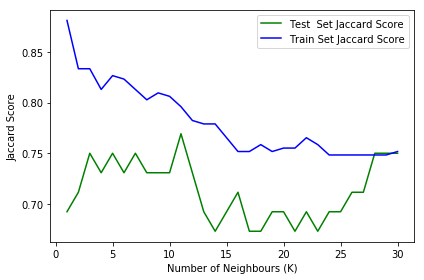

In [24]:
# Plot Jaccard score
plt.plot(range(1, max_k + 1), test_jaccard, 'g', label='Test  Set Jaccard Score')
plt.plot(range(1, max_k + 1), train_jaccard, 'b', label='Train Set Jaccard Score')
plt.legend()
plt.ylabel('Jaccard Score')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

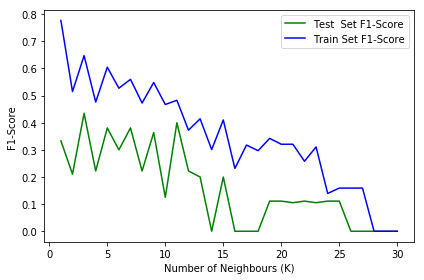

In [25]:
# Plot F1-score
plt.plot(range(1, max_k + 1), test_f1, 'g', label='Test  Set F1-Score')
plt.plot(range(1, max_k + 1), train_f1, 'b', label='Train Set F1-Score')
plt.legend()
plt.ylabel('F1-Score')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
# Fit the model
dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 50)
dec_tree.fit(features_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [28]:
# Predict test set
target_pred = dec_tree.predict(features_test)

# Evaluate results - Jaccard score
test_jaccard = metrics.accuracy_score(target_test, target_pred)
train_jaccard = metrics.accuracy_score(target_train, dec_tree.predict(features_train))

# Evaluate results - F1-score
test_f1 = metrics.f1_score(target_test, target_pred)
train_f1 = metrics.f1_score(target_train, dec_tree.predict(features_train))

print(f'Test Jaccard score is {test_jaccard}')
print(f'Test F1-score is {test_f1}')

Test Jaccard score is 0.6346153846153846
Test F1-score is 0.17391304347826086


In [29]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

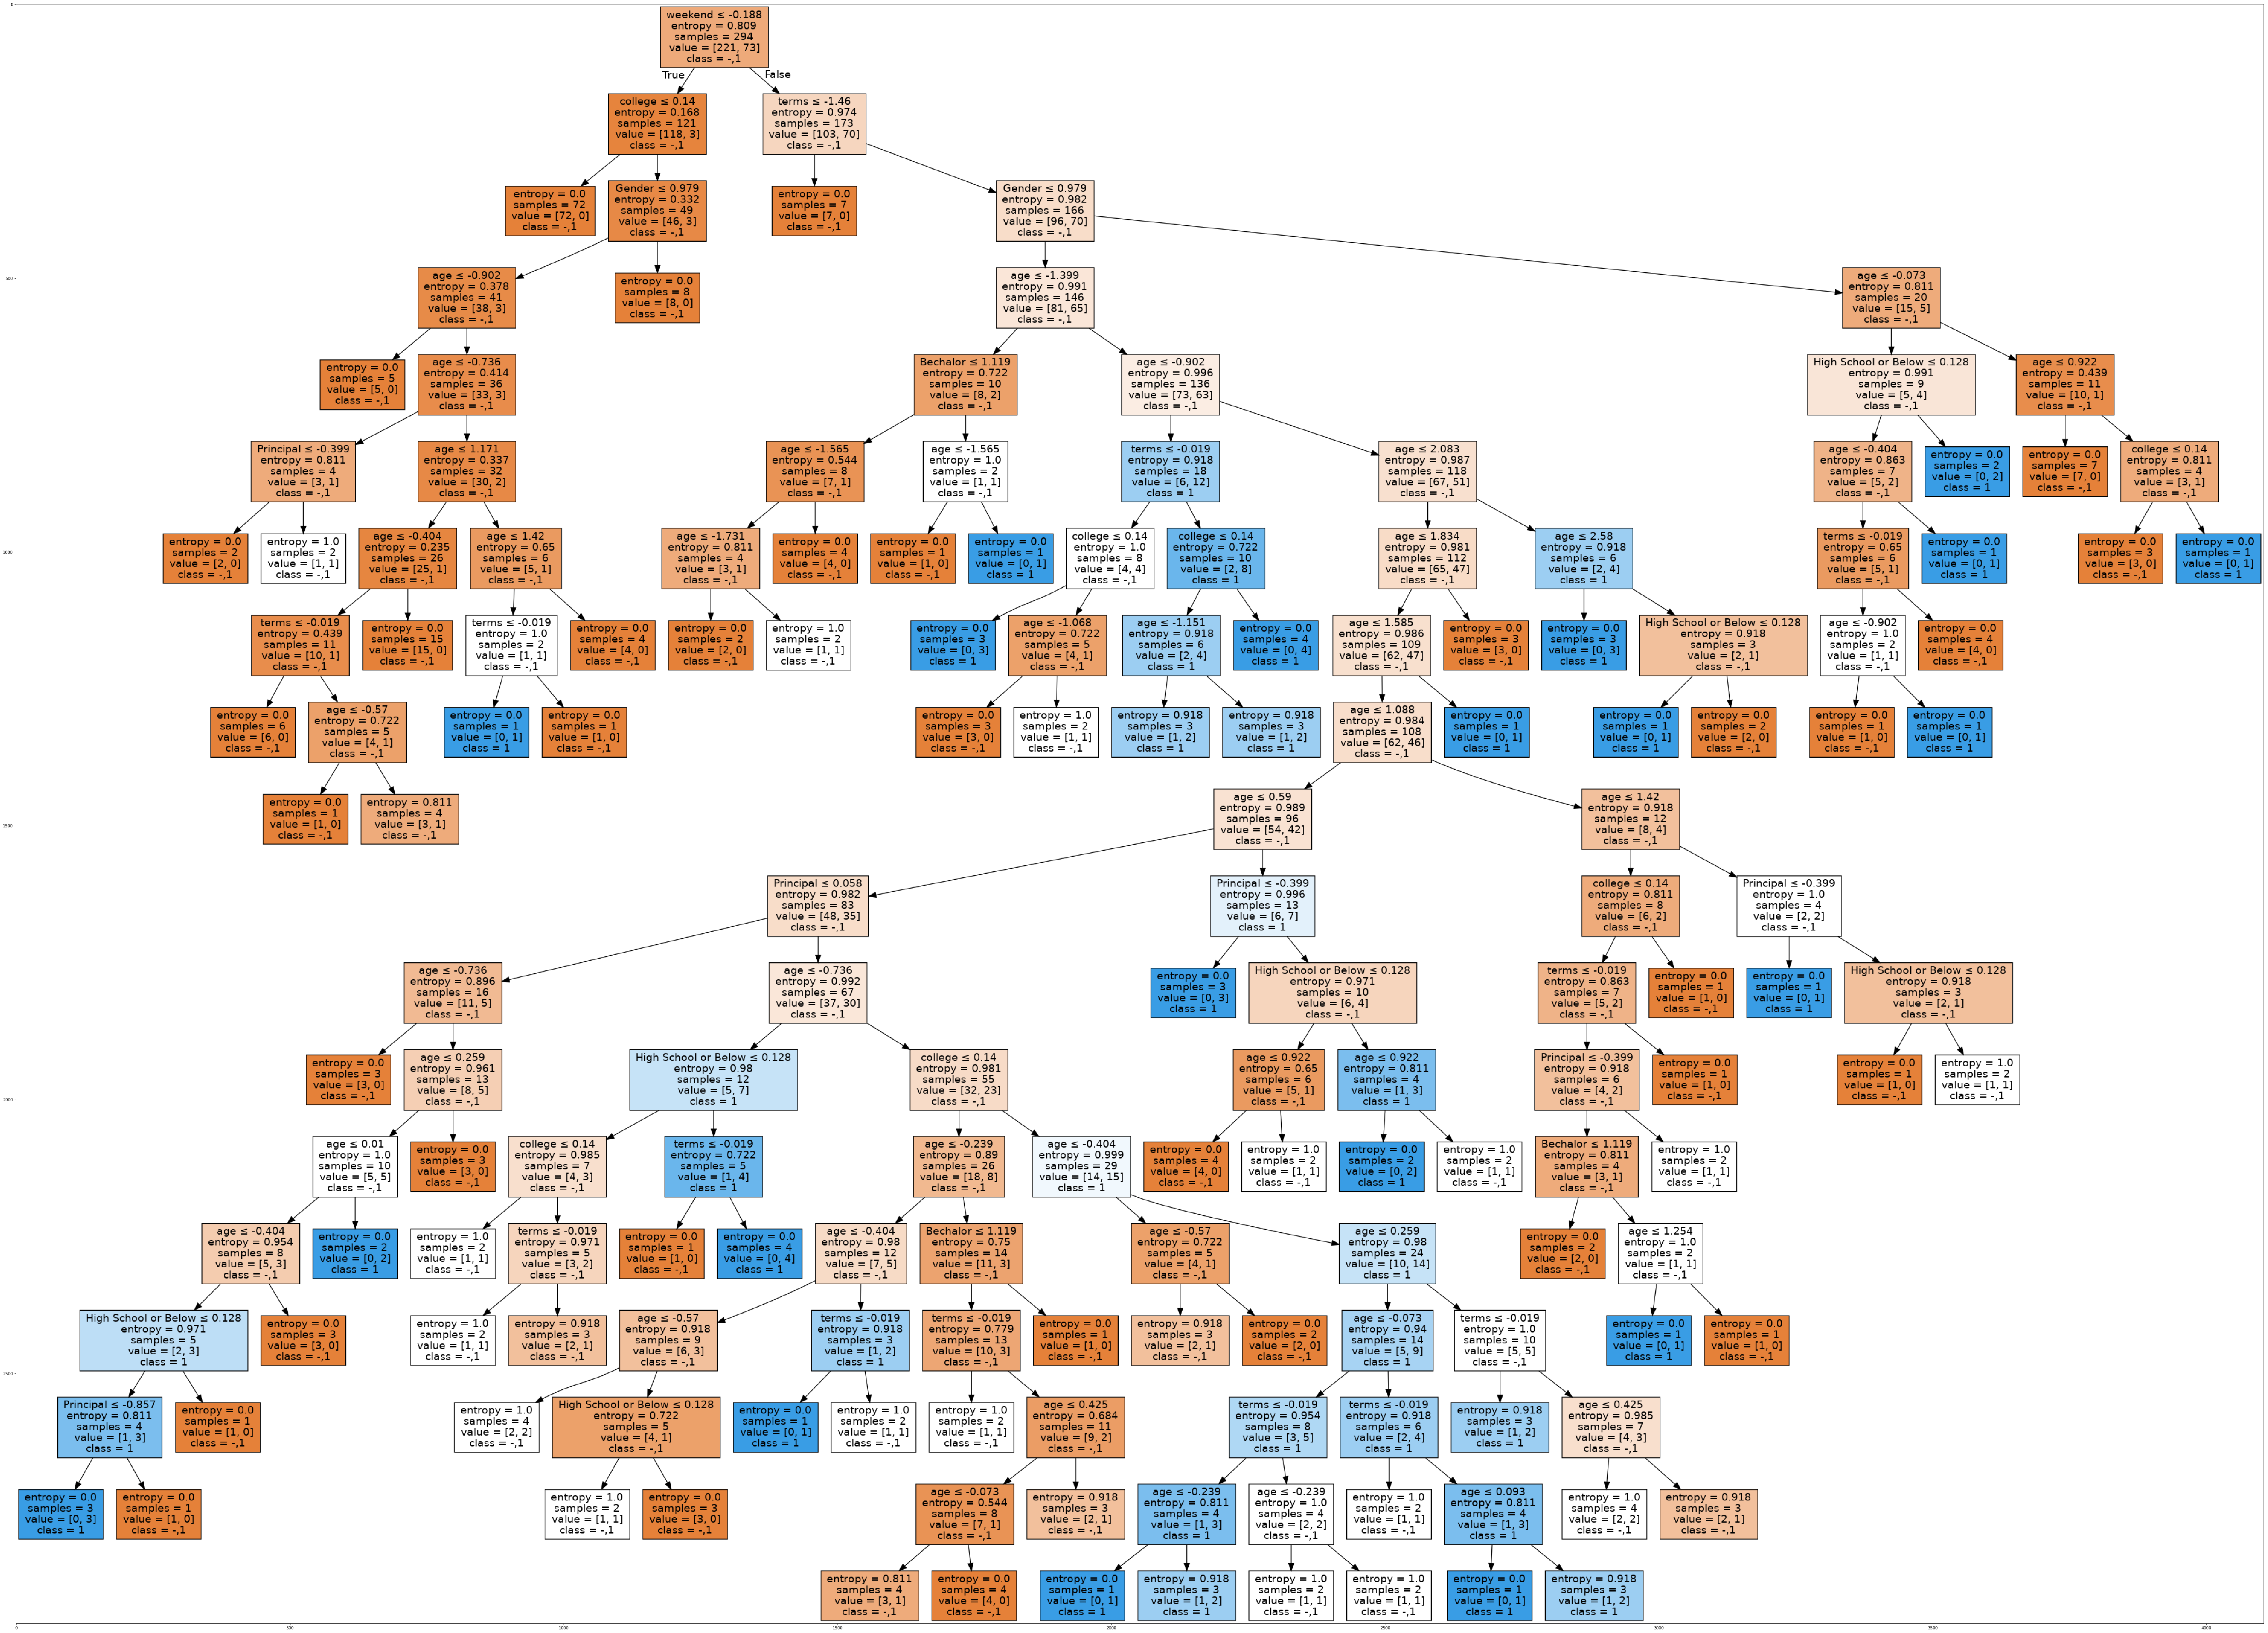

In [30]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

str_target_train = [",".join(item) for item in target_train.astype(str)]

dot_data = StringIO()
filename = "tree.png"
featureNames = new_df.columns[0:8]
targetNames = new_df['loan_status'].unique().tolist()
out = tree.export_graphviz(dec_tree, feature_names=featureNames, out_file=dot_data, class_names=np.unique(str_target_train), filled=True, special_characters=True, rotate=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation='nearest')

# Support Vector Machine

In [31]:
#import scipy.optimize as opt
from sklearn import svm

In [32]:
# Fit the model
machine = svm.SVC(kernel='poly', gamma='auto')
machine.fit(features_train, target_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
# Predict test set
target_pred = machine.predict(features_test)

# Evaluate results - Jaccard score
test_jaccard = metrics.accuracy_score(target_test, target_pred)
train_jaccard = metrics.accuracy_score(target_train, machine.predict(features_train))

# Evaluate results - F1-score
test_f1 = metrics.f1_score(target_test, target_pred)
train_f1 = metrics.f1_score(target_train, machine.predict(features_train))

print(f'Test Jaccard score is {test_jaccard}')
print(f'Test F1-score is {test_f1}')

Test Jaccard score is 0.7692307692307693
Test F1-score is 0.25


# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [35]:
import os, warnings
warnings.simplefilter('ignore')

max_c = 100
step = 0.01
test_jaccard = []
train_jaccard = []
test_f1 = []
train_f1 = []
test_l_loss = []
train_l_loss = []
best_lr = None

for i in range(1, int(100*(max_c + step)), int(100*step)):
    c = i/100
    # Fit model
    # 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
    lr = LogisticRegression(C=c, solver='liblinear')
    lr.fit(features_train, target_train)
    
    # Predict test set
    target_pred = lr.predict(features_test)
    
    # Evaluate results - Jaccard score
    current = metrics.accuracy_score(target_test, target_pred)
    
    if test_jaccard != [] and current > max(test_jaccard):
        best_lr = lr
        
    test_jaccard = np.append(test_jaccard, current)
    train_jaccard = np.append(train_jaccard, metrics.accuracy_score(target_train, lr.predict(features_train)))
    
    # Evaluate results - F1-score
    test_f1 = np.append(test_f1, metrics.f1_score(target_test, target_pred))
    train_f1 = np.append(train_f1, metrics.f1_score(target_train, lr.predict(features_train)))
    
    # Evaluate results - log loss
    test_l_loss = np.append(test_l_loss, log_loss(target_test, target_pred))
    train_l_loss = np.append(train_l_loss, log_loss(target_train, lr.predict(features_train)))

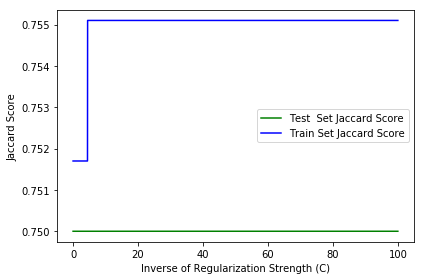

In [36]:
# Plot Jaccard score
plt.plot(np.arange(step, max_c + step, step).tolist(), test_jaccard, 'g', label='Test  Set Jaccard Score')
plt.plot(np.arange(step, max_c + step, step).tolist(), train_jaccard, 'b', label='Train Set Jaccard Score')
plt.legend()
plt.ylabel('Jaccard Score')
plt.xlabel('Inverse of Regularization Strength (C)')
plt.tight_layout()
plt.show()

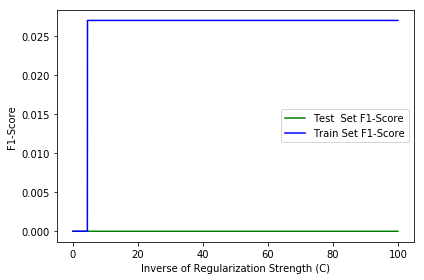

In [37]:
# Plot F1-score
plt.plot(np.arange(step, max_c + step, step).tolist(), test_f1, 'g', label='Test  Set F1-Score')
plt.plot(np.arange(step, max_c + step, step).tolist(), train_f1, 'b', label='Train Set F1-Score')
plt.legend()
plt.ylabel('F1-Score')
plt.xlabel('Inverse of Regularization Strength (C)')
plt.tight_layout()
plt.show()

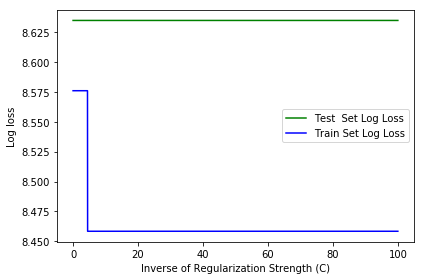

In [38]:
# Plot log loss
plt.plot(np.arange(step, max_c + step, step).tolist(), test_l_loss, 'g', label='Test  Set Log Loss')
plt.plot(np.arange(step, max_c + step, step).tolist(), train_l_loss, 'b', label='Train Set Log Loss')
plt.legend()
plt.ylabel('Log loss')
plt.xlabel('Inverse of Regularization Strength (C)')
plt.tight_layout()
plt.show()

In [39]:
print(f'Highest test Jaccard score is {test_jaccard.max()}')
print(f'Highest test F1-score is {test_f1.max()}')
print(f'Lowest test log loss is {test_l_loss.max()}')

Highest test Jaccard score is 0.75
Highest test F1-score is 0.0
Lowest test log loss is 8.634694098727671


# Model Evaluation using Test set

In [40]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [41]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-01-17 20:03:52--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-01-17 20:03:52 (355 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [42]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Pre-processing

In [43]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1, inplace=True)

# Back to original dataframe
new_df = pd.concat([Feature, test_df['loan_status']], axis=1)

# Binary values for the targets
new_df['loan_status'].replace({'PAIDOFF': -1, 'COLLECTION': 1}, inplace=True)

# Get targets and features
target = new_df['loan_status'].values
temp = new_df[['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor', 'High School or Below', 'college']]
features = preprocessing.StandardScaler().fit(temp).transform(temp)

### Applying models to test set

#### KNN

In [44]:
# Predict
pred = best_knn.predict(features)

# Evaluate
jaccard = metrics.accuracy_score(target, pred)
f1 = metrics.f1_score(target, pred)

# Print metrics
print(f'Jaccard score is {jaccard}')
print(f'F1-score is {f1}')

Jaccard score is 0.6296296296296297
F1-score is 0.09090909090909091


#### Decision Tree

In [45]:
# Predict
pred = dec_tree.predict(features)

# Evaluate
jaccard = metrics.accuracy_score(target, pred)
f1 = metrics.f1_score(target, pred)

# Print metrics
print(f'Jaccard score is {jaccard}')
print(f'F1-score is {f1}')

Jaccard score is 0.7592592592592593
F1-score is 0.5185185185185186


#### SVM

In [46]:
# Predict
pred = machine.predict(features)

# Evaluate
jaccard = metrics.accuracy_score(target, pred)
f1 = metrics.f1_score(target, pred)

# Print metrics
print(f'Jaccard score is {jaccard}')
print(f'F1-score is {f1}')

Jaccard score is 0.7592592592592593
F1-score is 0.23529411764705882


In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

          -1       0.76      0.97      0.86        40
           1       0.67      0.14      0.24        14

   micro avg       0.76      0.76      0.76        54
   macro avg       0.72      0.56      0.55        54
weighted avg       0.74      0.76      0.70        54

Confusion matrix, without normalization
[[39  1]
 [12  2]]


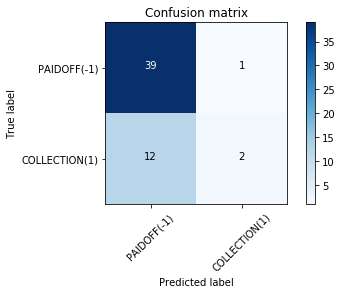

In [49]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(target, pred, labels=[-1, 1])
np.set_printoptions(precision=2)

print (classification_report(target, pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(-1)', 'COLLECTION(1)'], normalize=False,  title='Confusion matrix')

#### Logistic Regression

In [50]:
# Predict
pred = lr.predict(features)

# Evaluate
jaccard = metrics.accuracy_score(target, pred)
f1 = metrics.f1_score(target, pred)
l_loss = log_loss(target, pred)

# Print metrics
print(f'Jaccard score is {jaccard}')
print(f'F1-score is {f1}')
print(f'Log loss is {l_loss}')


Jaccard score is 0.7407407407407407
F1-score is 0.0
Log loss is 8.954497583865733


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.6296  | 0.0909   | NA      |
| Decision Tree      | 0.7407  | 0.5      | NA      |
| SVM                | 0.7593  | 0.2353   | NA      |
| LogisticRegression | 0.7407  | 0.0      | 8.9545  |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>